In the two previous posts I wrote about inverse problems ([part 1](https://miller-blog.com/inverse-problem-part-1/) and [part 2](https://miller-blog.com/inverse-problem-part-2/)). For a proper introduction into inverse problems I refer to these posts.  
In my last post about inverse problems, I have showed you how to describe a prediction (classification problem) in terms of an inverse problem and how to solve it. Making predictions without training data is pretty boring, because you cannot solve interesting, real world problems. I have mentioned, that training a model in terms of an inverse problem is possible and this is what I want to catch up on now. This will be showed based on the toy example of the [first post](https://miller-blog.com/inverse-problem-part-1/). In this post I want to quickly recap the inversion, which is the prediction and after that I describe the training procedure.

## Prediction

As already mentioned, the prediction is described here as an inversion. We are searching for $y=f_{\theta}^{-1}(x)$. In comparison to the previous posts the notation of x and y is switched. This represents the naming in machine learning better, where x represents the training data and y the target values. $f_\theta$ is the parameterized model, which describes the mapping from the latent space to the observation. $f_\theta$ is allowed to be any function, which can be differentiated with respect to $y$ and $\theta$. Training is changing the function parameters $\theta$ based on data. This is described later in this post.
We need $f_\theta^{-1}$ to make a prediction. In general $f_\theta^{-1}$ cannot be described analytically, therefore we are solving this problem iteratively with gradient descent:

$$h _{\theta}(x)=g_{\theta}(N, x)\approx f_{\theta}^{-1}(x)=\underset{y}{\operatorname{argmin}}(L_{\theta}(x, y)) $$
$$ g_{\theta}(n+1, x)=g_{\theta}(n, x) - \alpha \frac{L_{\theta}(x, y)}{dy} $$ 
$$ L_\theta(x, y)=\left(x-f_\theta(y)\right)^2$$ 
$$ \frac{L_{\theta}(x, y)}{dy}=-2\left(x-f_\theta(y)\right)\frac{df_\theta(y)}{dy} $$

A prediction is now done by calculating inverse model $y=h_\theta(x)$. $N$ is the number of gradient steps and $\alpha$ is the step width. The loss function $L_\theta(x,y)$ is defined as a quadratic loss function.  
The following lines of code show an inversion for the same toy example, shown in my previous [post](https://miller-blog.com/inverse-problem-part-1/). Here we have a linear function $f_\theta(y)=ay+b$, with a given $\theta=\left(\begin{array}{c}
a\\
b\\
\end{array}\right)=\left(\begin{array}{c}
2\\
-4\\
\end{array}\right)$.

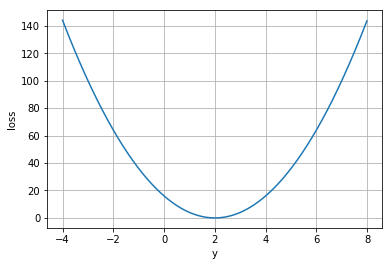

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

a = 2
b = -4

def f(y, a, b):
    return a*y + b

def df(y, a, b):
    return a

def L(x, y, a, b):
    return (x - f(y, a, b))**2

def dL(x, y, a, b):
    return -2 * (x - f(y, a, b)) * df(y, a, b)

gt_y = np.arange(-4, 8, 0.01)
gt_loss = L(0.0, gt_y, a, b)
plt.plot(gt_y, gt_loss)
plt.xlabel('y')
plt.ylabel('loss')
plt.grid()

y_opt=2.00


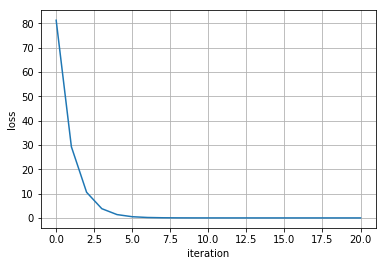

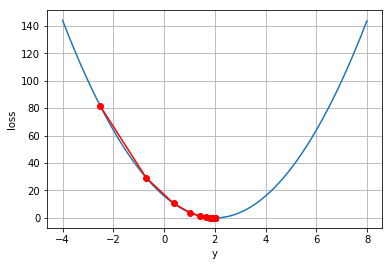

In [2]:
np.random.seed(42)

alpha = 0.05

current_y_opt = 20 * np.random.rand() - 10.0
current_loss = L(0.0, current_y_opt, a, b)
y_opt = [current_y_opt,]
loss = [current_loss,]

def g(n, x, a=2, b=-4):
    if n == 0:
        gn = current_y_opt
    else:
        gn1 = g(n-1, x, a, b)
        gn = gn1 - alpha * dL(x, gn1, a, b)

        current_loss = L(0.0, gn, a, b)
        y_opt.append(gn)
        loss.append(current_loss)
    
    return gn

from functools import partial
h = partial(g, 20)

current_y_opt = h(0.0, a, b)   
print('y_opt={0:.2f}'.format(current_y_opt))

plt.plot(loss)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

plt.plot(gt_y, gt_loss)
plt.plot(y_opt, loss, 'o-', color='red')
plt.xlabel('y')
plt.ylabel('loss')
plt.grid()
plt.show()

## Training

Training is fitting the parameters $\theta$ based on data. Since training is the inverse of predicting, this can be done in a similar way as in the previous inversion. First we have to define a loss function $T_\theta(x,y)$. In this case are using the sum of squared differences of $y$ and $h_\theta(x)$.

$$ T_{\theta}(x, y)=\sum_i{\left(y_i-h_{\theta}(x_i)\right)^2} $$

$\theta$ is the vector, which minimizes $T_\theta(x,y)$, given multiple training examples $(x_i, y_i)$.

$$ \theta^\star=\underset{\theta}{\operatorname{argmin}}(T_{\theta}(x, y)) $$

Again, as long as $T_\theta(x,y)$ is convex we can solve for $\theta$ with a gradient descent approach.

$$ \theta_{n+1}=\theta_{n+1}-\beta\frac{dT_{\theta}(x, y)}{d\theta} $$

We get $\frac{dT_{\theta}(x, y)}{d\theta}$ in a recursive way:

$$ \frac{dT_{\theta}(x, y)}{d\theta}=-2\sum_i \left(y_i-h_{\theta}(x_i)\right)\frac{dh_{\theta}(y_i)}{d\theta} $$
$$ \frac{dh_{\theta}(x)}{d\theta}=\frac{dg_{\theta}(N, x)}{d\theta} $$
$$ \frac{dg_{\theta}(n, x)}{d\theta} = \frac{dg_{\theta}(n-1,x)}{\theta}-\alpha \frac{d}{d\theta}\frac{dL_\theta(x, y)}{dy} $$
$$ = \frac{dg_{\theta}(n-1,x)}{\theta} - 2\alpha\left(
\begin{array}{c}
-x+2\theta_1 g_\theta(n-1,x)+\theta_1^2\frac{dg_\theta(n-1,x)}{d\theta_1}+\theta_2\\
\theta_1^2\frac{dg_\theta(n-1,x)}{d\theta_2}+\theta_1\\
\end{array}
\right)
$$

The following lines of code shows the implementation of this algorithm. The training examples are generated by sampling five uniformly distributed $y$ and calculating the coresponding $x$ with $x=f_\theta(y)$.  
One note, we stop $\theta_1$ to become smaller than 0.5. For small $\theta_1$ we have to iterate for a very long time, to see convergence. This is because the step-size, which is controlled by $\alpha$, is too small. A solution would be to use a more sofisticated optimization algorithm with momentum. However, this has not been tested yet.

a: 1.9999268051752905
b: -3.9998536215926457


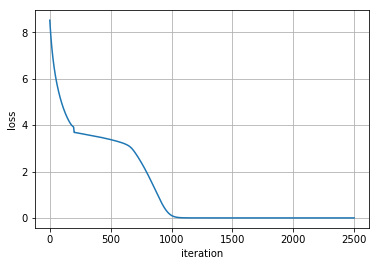

In [3]:
def T(x, y, a, b):
    return np.sum((y - h(x, a, b))**2)

def dga(n, x, a, b):
    if n == 0:
        return 0.0
    else:
        g_res = g(n-1, x, a, b)
        dga_res = dga(n-1, x, a, b)
        return dga_res - alpha * 2 * (-x + 2*a*g_res + a**2*dga_res + b)

def dgb(n, x, a, b):
    if n == 0:
        return 0.0
    else:
        dgb_res = dgb(n-1, x, a, b)
        return dgb_res - alpha * 2 * (a**2*dgb_res + a)

def dha(x, a, b):
    return dga(10, x, a, b)

def dhb(x, a, b):
    return dgb(10, x, a, b)

def dTa(x, y, a, b):
    return -2*np.sum((y - h(x, a, b))*dha(x, a, b))

def dTb(x, y, a, b):
    return -2*np.sum((y - h(x, a, b))*dhb(x, a, b))

current_a_opt = 2.0*np.random.rand()+1.5
current_b_opt = 0.0
y = np.array([-2.0, -1.0, 0.0, 1.0, 2.0])
x = f(y, a, b)
beta = 0.005
loss_T = []

for i in range(2500):
    tmp_a_opt = current_a_opt - beta * dTa(x, y, current_a_opt, current_b_opt)
    tmp_b_opt = current_b_opt - beta * dTb(x, y, current_a_opt, current_b_opt)

    current_a_opt = np.max([tmp_a_opt, 0.5])
    current_b_opt = tmp_b_opt

    current_loss = T(x, y, current_a_opt, current_b_opt)
    loss_T.append(current_loss)


print('a: ' + str(current_a_opt))
print('b: ' + str(current_b_opt))

plt.plot(loss_T)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('loss')

As we see, the algorithm is converging after a certain number of iterations and the loss is reaching zero. This would not be the case with noisy training examples.
Something special about this model is, that it can not only make predictions ($x\rightarrow y$), but there is also a generative model, which creates data points from the latent space ($y\rightarrow x$). This has interesting properties, as can be seen with [GANs](https://en.wikipedia.org/wiki/Generative_adversarial_network) (Generative adversarial networks). E.g. you could explore the latent space, by generating and visualizing the corresponding data points.

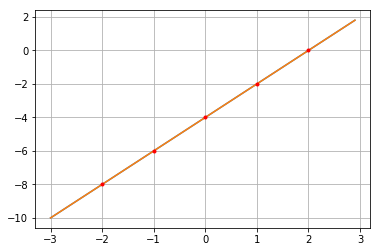

In [4]:
y_plot = np.arange(-3.0, 3.0, 0.1)
x_pred = f(y_plot, current_a_opt, current_b_opt)
x_gt = f(y_plot, a, b)
plt.plot(y_plot, x_gt)
plt.plot(y_plot, x_pred)
plt.plot(y, x, '.', color='red')
plt.grid()